# Spaceship

## Task description

To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

## File and Data Field Descriptions


### **train.csv**  - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.

PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.

CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

Destination - The planet the passenger will be debarking to.

Age - The age of the passenger.


VIP - Whether the passenger has paid for special VIP service during the voyage.

RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

Name - The first and last names of the passenger.

Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

### **test.csv** - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data.

Your task is to predict the value of Transported for the passengers in this set.

### **sample_submission.csv** - A submission file in the correct format.

PassengerId - Id for each passenger in the test set.

Transported - The target. For each passenger, predict either True or False.

Here are the first 5 rows of the data:

In [5]:
# Load data
import pandas as pd

train = pd.read_csv('datasets/train.csv')
test = pd.read_csv('datasets/test.csv')

train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


**PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

The number of a passenger within their group is arbitrary, so we don't need it. However, group numbers may be important, so we'll create a new feature "Group" and drop the PassengerId column.

In [7]:
train['Group'] = train['PassengerId'].str[:4]
train = train.drop('PassengerId', axis=1)
print(train['Group'].info())
print(train['Group'].describe())
print('Unique Values:')
print(train['Group'].unique())

<class 'pandas.core.series.Series'>
RangeIndex: 8693 entries, 0 to 8692
Series name: Group
Non-Null Count  Dtype 
--------------  ----- 
8693 non-null   object
dtypes: object(1)
memory usage: 68.0+ KB
None
count     8693
unique    6217
top       4498
freq         8
Name: Group, dtype: object
Unique Values:
['0001' '0002' '0003' ... '9278' '9279' '9280']


As we can see above, there are no missing values in Group.

Some other columns, though, have missing values. Let's explore if there are some patterns in missing data:

HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
Group             0
dtype: int64


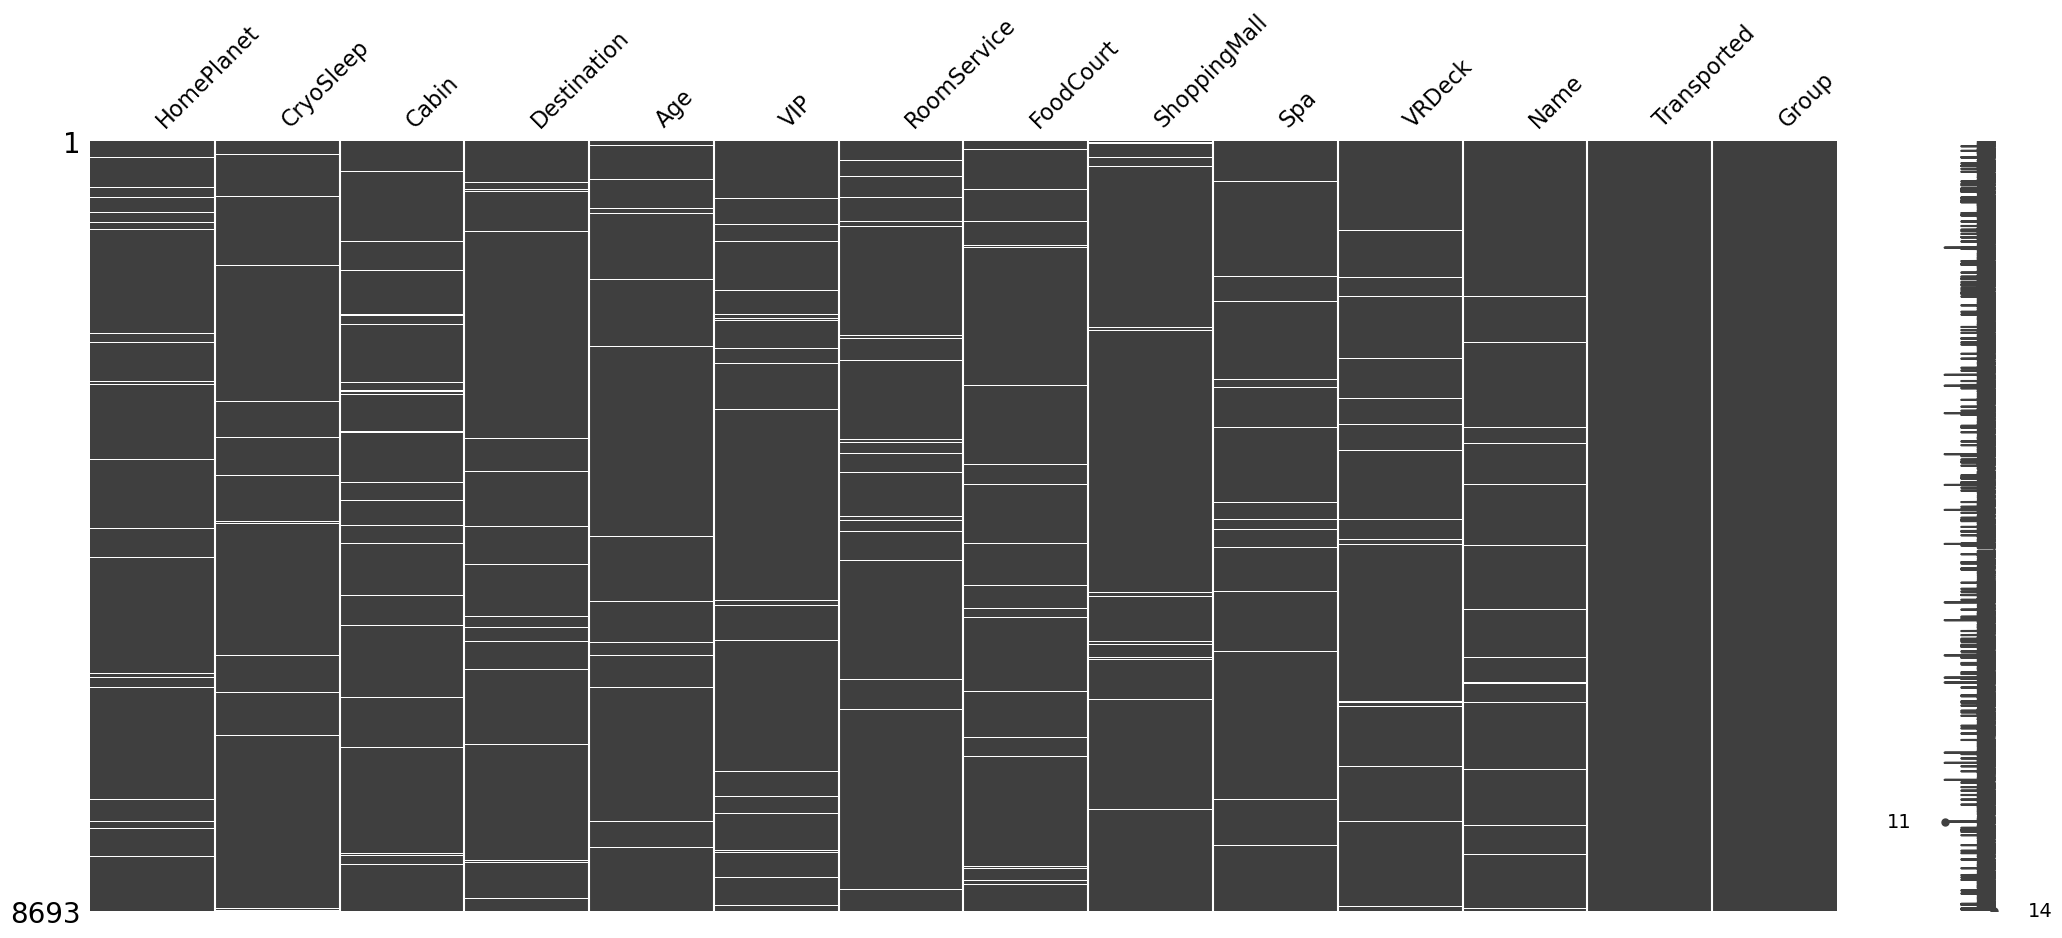

In [11]:
!pip install missingno

import missingno as msno
import matplotlib.pyplot as plt

# Print number of missing values in banking
print(train.isna().sum())

# Visualize missingness matrix
msno.matrix(train)
plt.show()

It seems that values are Missing At Random. We'll fill the missing values column by column, based on the description of the dataset.

**Name** - The first and last names of the passenger.

We don't need the first names, so we'll strip them:

In [12]:
### !!!! FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.

train.Name = train.Name.str.split(' ', 1).str[1]

C:\Users\mikej\AppData\Local\Temp\ipykernel_17120\2708217293.py:1: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  train.Name = train.Name.str.split(' ', 1).str[1]


We'll fill the missing values for Names based on the most common surname in their Group. If a passenger is alone in their group, we'll name them by the name of their group:

In [13]:
# Iterate through all the rows with missing data
for index in train[train['Name'].isna()].index:
    # Fill the missing values for lonely passengers:
    if len(train.loc[index, 'Group']) > 1:
        train.loc[index, "Name"] = train.loc[index, 'Group']
    # Fill the missing values for non-lonely passengers:
    else:
        train.loc[index, "Name"] = train[(train['Group'] == train.loc[index, 'Group']) & \
                (train['Name'].isna() == False)]['Name'].mode()[0]

As you can see below, now Name doesn't have missing values:

In [14]:
print(train['Name'].info())
print(train['Name'].describe())
print('Unique Values:')
print(train['Name'].unique())

<class 'pandas.core.series.Series'>
RangeIndex: 8693 entries, 0 to 8692
Series name: Name
Non-Null Count  Dtype 
--------------  ----- 
8693 non-null   object
dtypes: object(1)
memory usage: 68.0+ KB
None
count          8693
unique         2417
top       Casonston
freq             18
Name: Name, dtype: object
Unique Values:
['Ofracculy' 'Vines' 'Susent' ... '9230' '9246' 'Sionerorly']
